In [29]:
import numpy as np
import yaml

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from collections import Counter
import operator as op

import os
from together import Together
%load_ext autoreload
%autoreload 2

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Section 1: Existing CVs data analysis

Here is a recent collection of CVs from https://github.com/Stereotypes-in-LLMs/recruitment-dataset 
We will use these CVs as the basis for generating cover letters for our hiring model

In [30]:
df = pd.read_parquet('data/resumes.parquet', engine='pyarrow')
# top 10 positions in resume database
newdf = df.dropna().groupby("Position").count().sort_values("Moreinfo", ascending=False).head(20)

In [31]:
top_twenty_jobs = list(newdf.index.unique())

In [32]:
top_twenty_jobs

['Project Manager',
 'QA Engineer',
 'Junior QA Engineer',
 'Front-end developer',
 'Java Developer',
 'Junior Front-end Developer',
 'UI/UX Designer',
 'Manual QA Engineer',
 'Front-End Developer',
 'UX/UI Designer',
 'Python Developer',
 'Business Analyst',
 'Senior Software Engineer',
 'Product manager',
 'Frontend Developer',
 'IT Recruiter',
 'iOS Developer',
 'Senior Java Developer',
 'Senior QA Engineer',
 'Software Engineer']

In [33]:
pm = "Project Manager"
java_dev = "Java Developer"
pm_occupation_df = df[df["Position"]==pm]
java_dev_occupation_df = df[df["Position"]==java_dev]


In [34]:
# example entry 
"".join(java_dev_occupation_df.iloc[0].to_dict()['CV'].split('\r\n')).split('\n')

['',
 '01.11.2018   PE «SoloService»Position: Java Developer.• Software design, investigating technical solutions• Reviewing project documentation, analyzing requirements• Troubleshoot and analyze problems identified in the system software04.05.2018 – 31.10.2018   PE «SoloService» Position: IT Support Specialist.• provide user support for computer systems and user applications, including: website, mobile app, intranet, Outlook, Skype, operating systems (Windows and Linux);• installing and configuring computer hardware, software, mobile devices, video projection systems and audio systems;26.09.2017 – 03.05.2018   LLC «ЕКО» (supermarkets ЕКО)Position: Head of Project department.• project management of modernization, automation, reconstruction and  construction of trade objects;• to control the timing of project delivery;• establishment of consolidate budgets of projects;• organization of meetings, presentation of project (technology, visualization, business plan);• collaboration with pro

In [35]:
pm_occupation_df.iloc[0].to_dict()['CV']

'- Managing multiple projects at a time\r\n- Experience working with foreign customers\r\n- Successful team management with up to 7 members\r\n- SDLC understanding in terms of management perspective\r\n- Good communication skills\r\n- Project processes organization with Agile approaches(Agile, Kanban)\r\n- Working with the project documentation using Atlassian and Google services\r\n- Understanding of proper time management with further timelines control\r\n- Internal projects acceptance before delivering to the customer\r\n- Resources planning\r\n- Taking part in potential team members interviewing\r\n- Defend both customer and the company interests\r\n- Account management, pre-sales, upsales, risk management\n01.2020 - 04.2020\r\nProject manager/Account manager\r\n1. Working as a PM was responsible for project planning, resource planning, business communication, upsales.\r\n2. As an AM was involved in Outsataff projects monitoring and support. A few of the main responsibilities were 

In [36]:
## TODO: further explorations of CV data, bring 2-3 insights about the CV itself and Insights and highlights

#First: What words are used more? Collaboration base Terms or Technical terms?

def plot_position_words(position):
    pm_occupation_df = df[df["Position"]==position]
    all_cvs = "\n".join(list(pm_occupation_df['CV']))
    all_words = all_cvs.split(" ")
    all_long_words = [word for word in all_words if len(word) > 10]
    word_counts = Counter(all_long_words)
    top_ten = word_counts.most_common(20)
    words =  [item[0] for item in top_ten]
    counts = [item[1]/len(pm_occupation_df) for item in top_ten]
    #fig, ax = plt.subplots(figsize =(10, 6))
    return [words, counts]
    # Horizontal Bar Plot
    #ax.barh(words, counts)
    #ax.set_title('Frequency of Words in ' + position + " CVs",loc ='left', )
    #ax.invert_yaxis()
 
#plot_position_words("Java Developer")

#fig, axs = plt.subplots(4, 5, figsize=(100, 100))
#fig.suptitle('Word Frequencies')

'''for i in range(0, len(top_twenty_jobs)):
    print(top_twenty_jobs[i])
    plot_position_y = i % 4
    plot_position_x = i%5
    print(plot_position_y, plot_position_x)
    axs[plot_position_y, plot_position_x].set_title('Frequency of Words in ' + top_twenty_jobs[i] + " CVs",loc ='left', )
    axs[plot_position_y, plot_position_x].invert_yaxis()
    axs[plot_position_y, plot_position_x].barh(plot_position_words(top_twenty_jobs[i])[0], plot_position_words(top_twenty_jobs[i])[1])
fig.savefig("word-frequncies.png")'''


'for i in range(0, len(top_twenty_jobs)):\n    print(top_twenty_jobs[i])\n    plot_position_y = i % 4\n    plot_position_x = i%5\n    print(plot_position_y, plot_position_x)\n    axs[plot_position_y, plot_position_x].set_title(\'Frequency of Words in \' + top_twenty_jobs[i] + " CVs",loc =\'left\', )\n    axs[plot_position_y, plot_position_x].invert_yaxis()\n    axs[plot_position_y, plot_position_x].barh(plot_position_words(top_twenty_jobs[i])[0], plot_position_words(top_twenty_jobs[i])[1])\nfig.savefig("word-frequncies.png")'

## Section 2: Prompting LLMs for generating cover letters 

Now we will use a generic prompt to generate a cover letters for each resume using API calls

In [37]:
# Load the YAML file
with open('llm_api_keys.yaml', 'r') as file:
    config = yaml.safe_load(file)

together_api_key = config['services']['together']['api_key'] # replace with openai or anthropic also in yaml file

In [38]:
# example usage of Together AI 

client = Together(api_key=together_api_key) 
position = "Project Manager"
response = client.chat.completions.create(
    model="mistralai/Mixtral-8x7B-Instruct-v0.1",
    messages=[{"role": "user", "content": "Modify this resume to help me get a "+ position+" Job:" + "".join("".join(java_dev_occupation_df.iloc[0].to_dict()['CV'].split('\r\n')).split('\n'))}],
)
coverletter = response.choices[0].message.content

In [39]:
print(coverletter)

 [Your Name]
[Address]
[City, State ZIP]
[Phone Number]
[Email Address]

PROFESSIONAL EXPERIENCE

Project Manager, LLC "ЕКО" (supermarkets ЕКО), [City, State]
September 2017 - Present

* Lead the project department in the modernization, automation, reconstruction, and construction of trade objects
* Oversee project timelines and ensure delivery within established deadlines
* Establish consolidated budgets for projects and allocate resources accordingly
* Organize meetings, present project technology, visualization, and business plans to stakeholders
* Collaborate with project members, contractors, and suppliers to ensure project success

Head of Project Department, LLC "ЕКО" (supermarkets ЕКО), [City, State]
May 2018 - October 2018

* Provided user support for computer systems and user applications, including website, mobile app, intranet, Outlook, Skype, operating systems (Windows and Linux)
* Installed and configured computer hardware, software, mobile devices, video projection syste

In [40]:
# TODO: 

# decide on a prompt and use prompt + CVs to generate cover letters 

## Section 3: Training a simple hiring model 

We will now use fast text to create a hiring model which will make a binary decision of whether we should hire a candidate or not based on years of experience as the ground truth. Fasttext (https://fasttext.cc/) is an easy to use library you can run on your local computer to build text classification models or get embedding representations for different inputs. Here we will use Fast text to generate embeddings and then use a logistic classifier on top of it. 

### Step 1: Generate embeddings from cover letters 

In [10]:
import os
os.listdir('../../../Downloads')

['noun-star-923968.png',
 'Travelers_Itineraries - Travelers_Itineraries.csv',
 'doc_2088050_Prospect_List_Template_7588fef1-7e34-4a7d-ab9a-af39287dd5a6_5614822.xlsx',
 'Skit Presentation (1).pptx',
 'File_000-20240119T081318Z-001.zip',
 'SWE_Spotlight_Jiang_Grace_1.jpg',
 'exam1sol.pdf',
 'Paramount_Connie_Hong_Resume (1).pdf',
 'PS4 (1).pdf',
 'PS2-5.jpg',
 'Wim_Final (3).pdf',
 'IMG_3145.HEIC',
 '41p-randomness (1).pptx',
 '77398239-rio-de-janeiro-rj-08-03-1984-feminismo-dia-internacional-da-mulher-com-cartazes-e-e - Sergio Martinez Rey.webp',
 'practice_final_sol (1).pdf',
 '2024sp_optx_pset4_v5-6.jpg',
 'MATH120ps5sol (1).pdf',
 'CHStats200_HW6 2.pdf',
 'IMG_3446.HEIC',
 '1506.06980v2.pdf',
 'Grand Tour Explorer - Export (7)',
 'IMG_6490.HEIC',
 'CONNIE-C2B-HW1-U5L2-2024 (1).pdf',
 'Paper (1).pdf',
 'Jasmine_Vallejo.JPG',
 'sidford_sp24_optx_lec2_v1.pdf',
 'noun-star-934385.png',
 'groups2.7.pdf',
 'Ceserani. Architects.pdf',
 'ec941Lecture3.pptx',
 '92.jpeg',
 'Firefly moon refle

In [65]:
import fasttext
# load fast text vectors
ft = fasttext.load_model('../../../Downloads/cc.en.300.bin') # replace with your own path to the vector binary

In [66]:
def get_vector_rep(text): 
    tokens = text.lower().split() # feel free to use other tokenizations if you want
    if len(tokens) ==0:
        print(tokens)
        print(text)
        print(len(text))
    for i, t in enumerate(tokens):
        if i == 0:
            vec = ft.get_word_vector(t)
        else:
            vec += ft.get_word_vector(t)
    return vec

In [62]:
datasets = {0:list(java_dev_occupation_df['CV']), 1: list(pm_occupation_df['CV'])}

vector_rep = get_vector_rep("".join("".join(java_dev_occupation_df.iloc[0].to_dict()['CV'].split('\r\n')).split('\n')))

In [109]:
def create_test_train_dataset(true_dataset, false_dataset):
    x_s = []
    y_s = []
    for cv_s in true_dataset:
        x_s.append(get_vector_rep("".join("".join(cv_s.split('\r\n')).split('\n'))))
        y_s.append(1)
    for cv_s in false_dataset:
        x_s.append(get_vector_rep("".join("".join(cv_s.split('\r\n')).split('\n'))))
        y_s.append(0)
    return [x_s, y_s]

In [78]:
# TODO: build vector embeddings and lables for positive label examples experience more than 5 years, negative examples less than 5
training_data = create_test_train_dataset(datasets[1], datasets[0])

### Step 2: Build classifier for resume classification

In [79]:
no_applicant_modification_data = [training_data[0], training_data[1]]

In [110]:
#Generates (model, x_test, y_test) based on input (x, y) data
def train_model(data):
    x = data[0]
    y=data[1]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    clf = LogisticRegression(random_state=16)
    clf.fit(x_train, y_train)

    p = clf.predict_proba(x_test)[:, 1]
    p_acc = accuracy_score(y_test, p > 0.5)
    print("clf_acc", p_acc)
    return [clf, x_test, y_test]

#Plots confusion matrix
def plot_conf_matrix(xtest, ytest, output_model):
    cnf_matrix = metrics.confusion_matrix(ytest, output_model.predict(xtest))
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [81]:
test_resumes = []

with open("javadeveloper_to_pm.text", 'r') as f:
    for line in f:
        if len(line) >1:
            test_resumes.append(get_vector_rep(line))
        #print("new")


In [113]:
testmod = model_output[0].predict_proba(test_resumes)
testmod2 = model_output[0].predict(test_resumes)

In [114]:
testmod2

array([1, 0, 0, ..., 0, 0, 0])

In [120]:
z = 0
probss=[]
thinz = []
for i in testmod2:
    if i ==1:
        z+=1
        probss.append(testmod[z])
        thinz.append(z)
print(probss) 

[array([1.00000000e+00, 1.43970073e-12]), array([1.00000000e+00, 1.77526555e-16]), array([9.99988492e-01, 1.15078913e-05]), array([0.01032584, 0.98967416]), array([1.00000000e+00, 5.19039457e-12]), array([1.00000000e+00, 2.54302274e-10]), array([9.99813959e-01, 1.86040789e-04]), array([9.99932395e-01, 6.76045710e-05]), array([0.00298872, 0.99701128]), array([1.00000000e+00, 1.89768235e-13]), array([9.99998098e-01, 1.90164499e-06]), array([0.93829536, 0.06170464]), array([1.00000000e+00, 1.03791488e-12]), array([9.99999995e-01, 5.08006382e-09]), array([0.99784672, 0.00215328]), array([9.99999989e-01, 1.11644339e-08]), array([1.00000000e+00, 1.05311089e-39]), array([0.28060501, 0.71939499]), array([0.00495281, 0.99504719]), array([3.99110927e-05, 9.99960089e-01]), array([0.89914651, 0.10085349]), array([3.60395339e-07, 9.99999640e-01]), array([1.00000000e+00, 8.77896497e-11]), array([9.99433839e-01, 5.66161452e-04]), array([1.00000000e+00, 5.80410584e-17]), array([9.77087896e-05, 9.99902

clf_acc 0.9702439024390244
Intercept: [-0.52398802]


/Users/ch/miniforge3/envs/llm_jobs/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


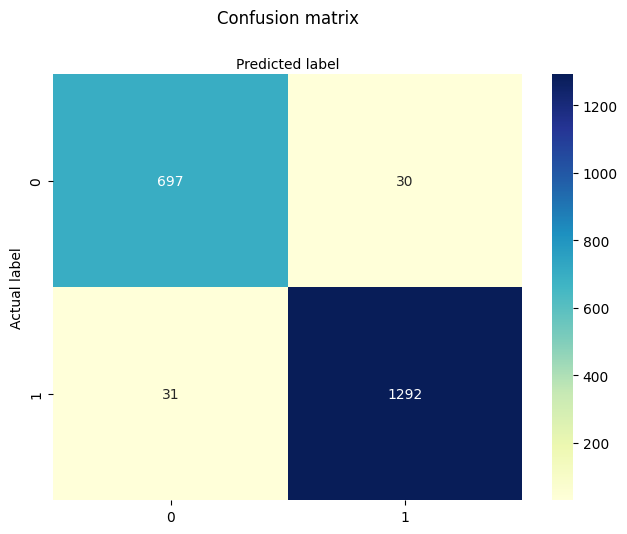

In [111]:
model_output = train_model(no_applicant_modification_data)
print('Intercept: {0}'.format(model_output[0].intercept_))
plot_conf_matrix(model_output[1], model_output[2], model_output[0])

## Section 4: Simulation manipulations and evaluate disparity 

In [27]:
# TODO: which all the tools above, use several different models to generate coverletters to be classified with the hiring model


In [18]:
# TODO: do all the modified resumes reach the threshold for classification as hire/interview? 
#Modify Java Resumes - see if accepted
with open('llm_api_keys.yaml', 'r') as file:
    config = yaml.safe_load(file)

together_api_key = config['services']['together']['api_key'] # replace with openai or anthropic also in yaml file



def create_modified_resumes(unmodifiedresumes, num_of_resumes, originalposition):
    # example usage of Together AI 
    modifiedresumes = []
    for resume in unmodifiedresumes[0:num_of_resumes]:
        client = Together(api_key=together_api_key) 
        position = "Project Manager"
        response = client.chat.completions.create(
            model="mistralai/Mixtral-8x7B-Instruct-v0.1",
            messages=[{"role": "user", "content": "Modify the following resume to help me get a "+ position+" Job:" + resume}],
        )

        #Trim out the AI conversation (I hope this faldskraewr! stuff).
        output = response.choices[0].message.content
        output = output[output.find("\n"):output.rfind('\n')]
        output = "".join("".join(output.split('\r\n')).split('\n'))
        modifiedresumes.append(output)

    with open(originalposition+'to'+position+'.txt', 'w') as f:
        for resume in modifiedresumes:
            f.write(f"{resume}\n")
    return modifiedresumes

In [12]:
df = pd.read_parquet('data/resumes.parquet', engine='pyarrow')

java_dev_occupation_df = df[df["Position"]=="Java Developer"]
java_to_pm_mod_resume = create_modified_resumes(list(java_dev_occupation_df['CV']), 2)

In [17]:
# TODO: do all the modified resumes reach the threshold for classification as hire/interview? 
#Modify Java Resumes - see if accepted


with open('llm_api_keys.yaml', 'r') as file:
    config = yaml.safe_load(file)

together_api_key = config['services']['together']['api_key'] # replace with openai or anthropic also in yaml file

df = pd.read_parquet('data/resumes.parquet', engine='pyarrow')

java_dev_occupation_df = df[df["Position"]=="Java Developer"]

def create_modified_resumes(unmodifiedresumes, num_of_resumes, originalposition):
    # example usage of Together AI 
    modifiedresumes = []
    for resume in unmodifiedresumes[0:num_of_resumes]:
        client = Together(api_key=together_api_key) 
        position = "Project Manager"
        response = client.chat.completions.create(
            model="mistralai/Mixtral-8x7B-Instruct-v0.1",
            messages=[{"role": "user", "content": "Modify the following resume to help me get a "+ position+" Job:" + resume}],
        )

        #Trim out the AI conversation (I hope this faldskraewr! stuff).
        output = response.choices[0].message.content
        output = output[output.find("\n"):output.rfind('\n')]
        output = "".join("".join(output.split('\r\n')).split('\n'))
        modifiedresumes.append(output)

    with open(originalposition+'to'+position+'.txt', 'w') as f:
        for resume in modifiedresumes:
            f.write(f"{resume}\n")
    return modifiedresumes

java_to_pm_mod_resume = create_modified_resumes(list(java_dev_occupation_df['CV']), 2)

2. Completed Java Developer course at EPAM - 05.18-08.183. Obtained B2 level English certificate from Red Arrow4. Currently attending Frontend courses at GoIt - 09.18-present01.2018 – present Java DeveloperProject: Cloud-based file management system.Responsibilities:* Improved code efficiency, reduced executable size, and increased readability through code refactoring, optimization, and documentation* Implemented user access system into existing cloud-based application* Managed database migration using Liquibase and resolved regression issues during upgrade* Integrated full-text search using ElasticSearch* Exposed RESTful API using Swagger* Developed specification-based test cases to verify application implementation correctnessTechnical Skills:* Java 8, Spring, Hibernate, Liquibase, Maven, Log4j, MySQL, Docker, Git, Junit, Mockito.


In [14]:
with open('your_file.txt', 'w') as f:
    for resume in java_to_pm_mod_resume:
        f.write(f"{resume}\n")